# Differential Expression Gene with BRICK

BRICK can be used to visualize the markers record in knowledge graph and reasoning the annotation result.

## Loading Packages and Data

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import BRICK

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)
BRICK.config_llm(modeltype='ChatOpenAI', 
                 api_key="sk-kpsteSkpDGl1xBmDEcC7D51b968e43499092826f17286b55",  
                 base_url='http://10.224.28.80:3000/v1', 
                 llm_params={'model_name': 'qwen-max'})

Graph database has been configured and initialized successfully.
LLM has been configured and initialized successfully.


In [2]:
adata = sc.read('./data/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy()
sc.tl.rank_genes_groups(adata, groupby='KGannotator_refinement', pts=True)

adata

AnnData object with n_obs × n_vars = 822 × 14821
    obs: 'sample_name', 'n_genes', 'n_counts', 'annotation', 'leiden', 'KGannotator2', 'delta_specific', 'gamma_specific', 'leiden_combined', 'KGannotator_refinement'
    var: 'Ensembl_id', 'Symbol', 'NCBI_id', 'MGI_id', 'mean', 'std'
    uns: 'KGannotator2_colors', 'KGannotator_refinement_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'annotation_au'
    varm: 'PCs'
    layers: 'lognorm'
    obsp: 'connectivities', 'distances'

In [3]:
BRICK.pp.rank_genes_groups2df(adata)

## Taking 'pancreatic PP cell' as example

In [5]:
select_group = 'pancreatic PP cell'
DEG_df = adata.uns['rank_genes_groups_df'][select_group]
DEG_df.head()

,names,scores,pvals,pvals_adj,logfoldchanges,pts,pts_rest
names,,,,,,,
Pcsk2,Pcsk2,18.791948,5.048707e-19,2.876849e-17,2.791833,1.00,0.700748
Pyy,Pyy,14.531604,4.579079e-12,9.085212e-11,6.055765,1.00,0.714464
Ppy,Ppy,8.546126,5.788611e-08,6.003709e-07,6.044227,1.00,0.874065
Peg3,Peg3,7.407348,3.735860e-07,3.378229e-06,2.806904,1.00,0.405237
Pcsk1n,Pcsk1n,7.395367,3.162212e-07,2.894820e-06,2.251464,0.95,0.620948


In [6]:
## optional: use simple flavor to calculate logfoldchanges instead of scanpy
interval = 0.001


adata.var['mean_in'] = np.array(adata[adata.obs['KGannotator_refinement'] == 'pancreatic PP cell'].X.mean(axis=0))[0]
adata.var['mean_out'] = np.array(adata[adata.obs['KGannotator_refinement'] != 'pancreatic PP cell'].X.mean(axis=0))[0]
DEG_df['mean_in'] = adata.var['mean_in']
DEG_df['mean_out'] = adata.var['mean_out']
DEG_df['logfoldchanges'] = np.log2((DEG_df['mean_in']+interval) / (DEG_df['mean_out']+interval))

## query BRICK

query BRICK to get markers of prior knowledge for pancreatic PP cell

In [7]:
query_df = BRICK.qr.query_neighbor([select_group], source_entity_type='Cell', target_entity_type='Gene', relation='marker_of')
query_df = query_df.loc[query_df['path.2.name'].isin(adata.var_names)]
query_df.head(3)

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.1.relation_confidence,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,A PP cell located in the islets of the pancreas.<xref>MESH:D050418|FMA:70588|BTO:0000805</xref>,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell of pancreatic islet|PP-cell of pancreatic islet,Cell,marker_of,[UBERON:0001264],[SCT000000966],1,[DEG_of],marker_of,[0.506],zinc finger CCCH type containing 7B<loc>:15 E1|15 38.23 cM<xref>ENSEMBL:ENSMUSG00000022390|MGI:1328310</xref>,NCBI:20286,Zc3h7b,Gm627|Scrg3|Zc2h7b|mKIAA1031,Gene
2,A PP cell located in the islets of the pancreas.<xref>MESH:D050418|FMA:70588|BTO:0000805</xref>,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell of pancreatic islet|PP-cell of pancreatic islet,Cell,marker_of,[UBERON:0001264],[SCT000000966],1,[DEG_of],marker_of,[0.503],complexin 2<loc>:13 B1|13 28.59 cM<xref>ENSEMBL:ENSMUSG00000025867|ENSEMBL:ENSMUSG00000112941|MGI:104726</xref>,NCBI:12890,Cplx2,921-L|Gm34843,Gene
4,A PP cell located in the islets of the pancreas.<xref>MESH:D050418|FMA:70588|BTO:0000805</xref>,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell of pancreatic islet|PP-cell of pancreatic islet,Cell,marker_of,"[UBERON:0001911, UBERON:0001981, UBERON:0001264, UBERON:0001255, UBERON:0002048, UBERON:0001630, UBERON:0001723, UBERON:0002371, UBERON:0001013, UBERON:0002370, UBERON:0003126, UBERON:0002113, UBERON:0002097, UBERON:0000991, UBERON:0000948, UBERON:0002106, UBERON:0002107, UBERON:0000955, UBERON:0000160]",[SCT000000793],1,[DEG_of],marker_of,[0.9089999999999999],"zinc finger, DBF-type containing 2<loc>:1|1 C2<xref>ENSEMBL:ENSMUSG00000027520|MGI:1921134</xref>",NCBI:73884,Zdbf2,4930431J08Rik|9330107J05Rik,Gene


## visualize markers of prior knowledge in volcano plot

(0.0, 12.0)

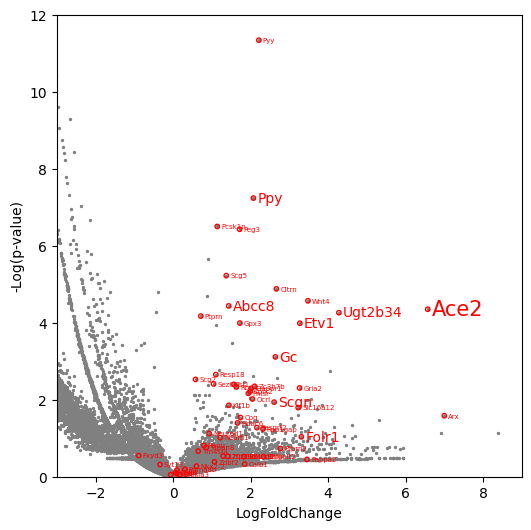

In [8]:
DEG_df['x'] = DEG_df['logfoldchanges']
DEG_df['y'] = -1 * np.log10(DEG_df['pvals'])


query_df.index = query_df['path.2.name']
for key in ['x', 'y']:
    query_df[key] = DEG_df[key]


fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(DEG_df['x'], DEG_df['y'], s = 2, color = 'grey')

ax.scatter(query_df['x'], query_df['y'], s = 10, facecolors='none', color = 'Red')

for _, row in query_df.iterrows():
    ax.text(row['x']+0.1, row['y'], row['path.2.name'], fontsize=row['path.1.info_source_length'] * 5, color='red', va='center') 


ax.set_xlabel('LogFoldChange')
ax.set_ylabel('-Log(p-value)')


ax.set_xlim([-3, 9])
ax.set_ylim([0, 12])

In [9]:
fig.savefig('./PP_cell_DEG_volcano.pdf')

## Interprete DEG result

In [10]:
BRICK.inp.differetial_expression_gene_inspector(DEG_df, query_df, selected_cell_type=select_group, u_question=None)

'### Interpretation of Differential Expression Gene (DEG) Results for Pancreatic PP Cells\n\n#### 1. Summary of Valuable Findings and Conclusions\n\n**a. Highly Significant DEGs:**\n- **Pcsk2, Pyy, Ppy, Peg3, Pcsk1n, Cpe, Scg5, Cltrn, Gnas, Wnt4, Abcc8, Ace2, Ugt2b34, Ptprn, Etv1, Gpx3, Lgals3bp, Aplp1, Gc, Eef1a2, Cst3, Resp18, C1galt1, Ttr, Scg2, Serping1, Gcg, Sez6l2, Isl1, Srpr, Zc3h7b, Rbp4, Gria2, Elapor1, Cplx2, Pnisr, Pura, Itm2b, Tmem59, Chga, Maged1, Gls, Ocrl, Ptprt, Xist, Nap1l5, Meg3, Scgn, Rcn3, Uchl1, Kif1b, Efr3a:**\n  - These genes show significant differential expression (p-values < 0.05, adjusted p-values < 0.05).\n  - **Pcsk2, Pyy, Ppy, and Peg3** are the top DEGs with the highest scores and lowest p-values, indicating their strong association with the pancreatic PP cell phenotype.\n  - **Pyy, Ppy, and Peg3** have high log fold changes (logFC > 2), suggesting they are highly upregulated in the pancreatic PP cells.\n\n**b. Functional Relevance:**\n- **Pcsk2 (Proprote